# For a single qubit, Quantum Error Mitigation (QEM) technique: Zero-Noise Extrapolation (ZNE) with Qiskit

$ $

In this notebook, we have implemented a __Quantum Error Mitigation (QEM)__ technique, called __Zero-Noise Extrapolation (ZNE)__, with the quantum software development kit __Qiskit__.

The ZNE is used in quantum computing to mitigate the impact of noise and errors in quantum systems. It is specifically employed to improve the accuracy of quantum algorithms executed on Noisy Intermediate-Scale Quantum (NISQ) devices.

The basic idea behind ZNE involves running the quantum algorithm multiple times with different levels of noise, ranging from low to high. By analyzing the correlation between the noise level and the obtained results, it becomes possible to extrapolate the expected outcome when the noise is completely eliminated or reduced to a negligible level. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy



from qiskit import QuantumCircuit, transpile                   #!pip install qiskit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram                #!pip install qiskit[visualization]

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, 
                              depolarizing_error, thermal_relaxation_error)


## Quantum circuit

Our quantum circuit is made of a single qubit rotation around the y-axis $R_y$ by an angle.

In [2]:
ang = np.pi/5

circ = QuantumCircuit(1)
circ.ry(ang, 0)  


## Ideal simulator

        ┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0 


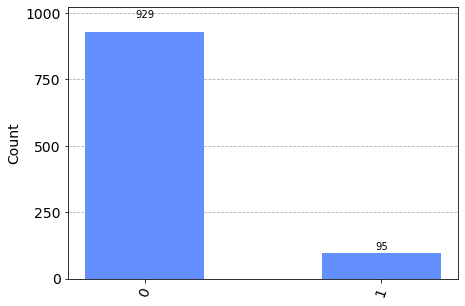

In [3]:
sim_ideal = AerSimulator()

circ_copy = copy.deepcopy(circ)
circ_copy.measure_all()
print(circ_copy)
result_ideal = sim_ideal.run(circ_copy).result()
counts_ideal = result_ideal.get_counts()


plot_histogram(counts_ideal)

In [4]:
prob_ideal = [counts_ideal['0'], counts_ideal['1']]
prob_ideal = prob_ideal/np.sum(prob_ideal)
print(f'extimated prob_ideal = {prob_ideal}')

prob = np.array([np.cos(ang/2), np.sin(ang/2)])**2
print(f'true prob = {prob}')

extimated prob_ideal = [0.90722656 0.09277344]
true prob = [0.9045085 0.0954915]


## Noise model 

In [5]:
noise_model = NoiseModel()                               # create an empty noise model

param_ = 0.3
error = depolarizing_error(param=param_, num_qubits=1)      # add depolarizing error to all single qubit ry gates
noise_model.add_all_qubit_quantum_error(error, ['rx', 'ry', 'rz'])


print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'ry', 'rz', 'sx']
  Instructions with noise: ['rz', 'rx', 'ry']
  All-qubits errors: ['rx', 'ry', 'rz']


## Noisy simulator

        ┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0 
{'1': 220, '0': 804}


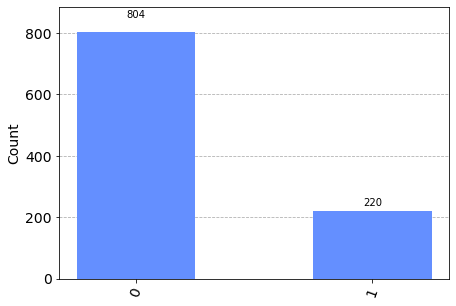

In [6]:
sim_noise = AerSimulator(noise_model=noise_model)            # create noisy simulator backend

circ_copy = copy.deepcopy(circ)
transpiled = transpile(circ_copy, sim_noise)                      # transpile circuit for noisy basis gates
transpiled.measure_all()
print(transpiled)

result_noise = sim_noise.run(transpiled).result()            # run and get counts
counts_noise = result_noise.get_counts()
print(counts_noise)


plot_histogram(counts_noise)

In [7]:
prob_noise = [counts_noise['0'], counts_noise['1']]
prob_noise = prob_noise/np.sum(prob_noise)
print(f'extimated prob_noise = {prob_noise}\n')

print(f'extimated prob_ideal = {prob_ideal}')
print(f'true prob = {prob}')

extimated prob_noise = [0.78515625 0.21484375]

extimated prob_ideal = [0.90722656 0.09277344]
true prob = [0.9045085 0.0954915]


$ $
# 1st implementation
## Quantum Error Mitigation: Zero-Noise Extrapolation (ZNE)

The basic idea behind this ZNE implementation is repeatedly the noisy quantum circuit ($R_y$ gate) $k$ times and the measurement at the end.
Here, $k=1,\cdots,kmax$ acts as a measure of the noise level. As k increase, more and more noise accumulates.


By analyzing the relation between the noise level ($k$) and the obtained probabilities for outcomes 0 and 1, it becomes possible to extrapolate the probabilities when the noise is eliminated (that corresponds to $k=0$). That will be the obtained error mitigated value. 

In [8]:

def repeat_circuit(k):
    print(f'k={k}')
    circ_copy = copy.deepcopy(circ)
    transpiled = transpile(circ_copy, sim_noise)                     # transpile circuit for noisy basis gates
    for _ in range(k-1):
        transpiled = transpiled.compose(transpile(circ_copy, sim_noise))
        
    
    transpiled.measure_all()
    print(transpiled)
    result_noise = sim_noise.run(transpiled).result()         # run and get counts
    counts_noise = result_noise.get_counts()
    prob_noise = [counts_noise['0'], counts_noise['1']]
    prob_noise = prob_noise/np.sum(prob_noise)
    return prob_noise

kmax = 9
ks = []
prob_noise_list = []

for k in range(1, kmax):
    ks.append(k)
    #print(f'k={k}')
    
    prob_noise = repeat_circuit(k)
    prob_noise_list.append(prob_noise)
    

prob_noise_list = np.array(prob_noise_list)  
prob_noise_list

k=1
        ┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0 
k=2
        ┌─────────┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├┤ Ry(π/5) ├─░─┤M├
        └─────────┘└─────────┘ ░ └╥┘
meas: 1/══════════════════════════╩═
                                  0 
k=3
        ┌─────────┐┌─────────┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├┤ Ry(π/5) ├┤ Ry(π/5) ├─░─┤M├
        └─────────┘└─────────┘└─────────┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 
k=4
        ┌─────────┐┌─────────┐┌─────────┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├┤ Ry(π/5) ├┤ Ry(π/5) ├┤ Ry(π/5) ├─░─┤M├
        └─────────┘└─────────┘└─────────┘└─────────┘ ░ └╥┘
meas: 1/════════════════════════════════════════════════╩═
                                                        0 
k=5
        ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├┤ Ry(π/5) ├┤ Ry(π/5) ├┤ Ry(π/5) ├┤ Ry(π/5

array([[0.77734375, 0.22265625],
       [0.57910156, 0.42089844],
       [0.45214844, 0.54785156],
       [0.40527344, 0.59472656],
       [0.41796875, 0.58203125],
       [0.453125  , 0.546875  ],
       [0.47851562, 0.52148438],
       [0.50390625, 0.49609375]])

After error mitigation, probability (expectation value) for the outcome 0 = 0.922


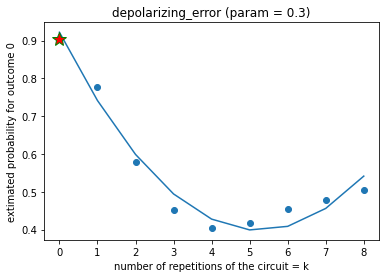

After error mitigation, probability (expectation value) for the outcome 1 = 0.078


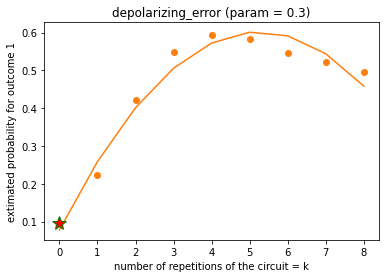

In [9]:
deg = 2

def plot(probs, outcome):
    f = np.poly1d(np.polyfit(x=ks, y=probs, deg=deg))  # fitted continuous function
    plt.plot([f(k) for k in range(kmax)], c=f'C{outcome}')
    print(f'After error mitigation, probability (expectation value) for the outcome {outcome} = {round(f(0),3)}')
    
    plt.scatter(ks, probs, c=f'C{outcome}')
    plt.plot(0, prob[outcome], marker="*", markersize=15, 
             markeredgecolor="green",markerfacecolor="red") # true prob probability marked by red star
    plt.title(f'depolarizing_error (param = {param_})')
    plt.ylabel(f'extimated probability for outcome {outcome}')
    plt.xlabel('number of repetitions of the circuit = k')
    plt.show()
    return 

    
for outcome in range(2):
    plot(prob_noise_list[:,outcome], outcome)


In [10]:
print(f'extimated prob_ideal = {prob_ideal}')
print(f'true prob = {prob}')

extimated prob_ideal = [0.90722656 0.09277344]
true prob = [0.9045085 0.0954915]


$ $

# 2nd implementation
## Quantum Error Mitigation: Zero-Noise Extrapolation (ZNE)

In this ZNE implementation, measurement is not at the end but after every $Ry$.

In [11]:
def repeat_circuit(k):
    print(f'k={k}')
    circ_copy = copy.deepcopy(circ)
    circ_copy.measure_all()
    transpiled = transpile(circ_copy, sim_noise)                     # transpile circuit for noisy basis gates
    for _ in range(k-1):
        transpiled = transpiled.compose(transpile(circ_copy, sim_noise))
        
    print(transpiled)
    result_noise = sim_noise.run(transpiled).result()         # run and get counts
    counts_noise = result_noise.get_counts()
    prob_noise = [counts_noise['0'], counts_noise['1']]
    prob_noise = prob_noise/np.sum(prob_noise)
    return prob_noise


ks = []
prob_noise_list = []

for k in range(1, kmax):
    ks.append(k)
    #print(f'k={k}')
    
    prob_noise = repeat_circuit(k)
    prob_noise_list.append(prob_noise)
    

prob_noise_list = np.array(prob_noise_list)  
prob_noise_list

k=1
        ┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘
meas: 1/═══════════════╩═
                       0 
k=2
        ┌─────────┐ ░ ┌─┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘└─────────┘ ░ └╥┘
meas: 1/═══════════════╩════════════════╩═
                       0                0 
k=3
        ┌─────────┐ ░ ┌─┐┌─────────┐ ░ ┌─┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├┤ Ry(π/5) ├─░─┤M├┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘└─────────┘ ░ └╥┘└─────────┘ ░ └╥┘
meas: 1/═══════════════╩════════════════╩════════════════╩═
                       0                0                0 
k=4
        ┌─────────┐ ░ ┌─┐┌─────────┐ ░ ┌─┐┌─────────┐ ░ ┌─┐┌─────────┐ ░ ┌─┐
     q: ┤ Ry(π/5) ├─░─┤M├┤ Ry(π/5) ├─░─┤M├┤ Ry(π/5) ├─░─┤M├┤ Ry(π/5) ├─░─┤M├
        └─────────┘ ░ └╥┘└─────────┘ ░ └╥┘└─────────┘ ░ └╥┘└─────────┘ ░ └╥┘
meas: 1/═══════════════╩════════════════╩════════════════╩════════════════╩═
                       0       

array([[0.79296875, 0.20703125],
       [0.69238281, 0.30761719],
       [0.58691406, 0.41308594],
       [0.546875  , 0.453125  ],
       [0.51074219, 0.48925781],
       [0.54492188, 0.45507812],
       [0.50292969, 0.49707031],
       [0.49609375, 0.50390625]])

After error mitigation, probability (expectation value) for the outcome 0 = 0.892


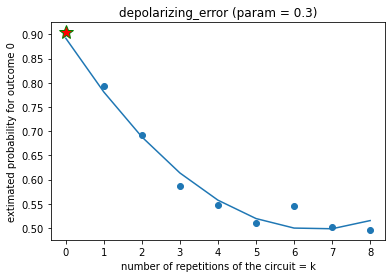

After error mitigation, probability (expectation value) for the outcome 1 = 0.108


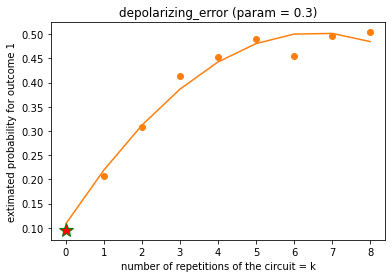

In [12]:
for outcome in range(2):
    plot(prob_noise_list[:,outcome], outcome)

In [13]:
print(f'extimated prob_ideal = {prob_ideal}')
print(f'true prob = {prob}')

extimated prob_ideal = [0.90722656 0.09277344]
true prob = [0.9045085 0.0954915]


# 